# **Neural Style Transfer in Keras Tensorflow 2.0**

---


Implement the **Neural Style Transfer Algorithm** using Keras with Tensorflow 2.0. 

We apply the technique known as *neural style transfer* shown in the research published here <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

1. Setup, load modules and helper function
2. Implementing our model from scratch
3. Build the model
4. Extract style and content
5. Running Gradient Descent
6. Training the model
7. Save our image
8. Fast Style Transfer using TF-Hub

Source - https://www.tensorflow.org/tutorials/generative/style_transfer



## **1. Setup, load modules and helper functions**




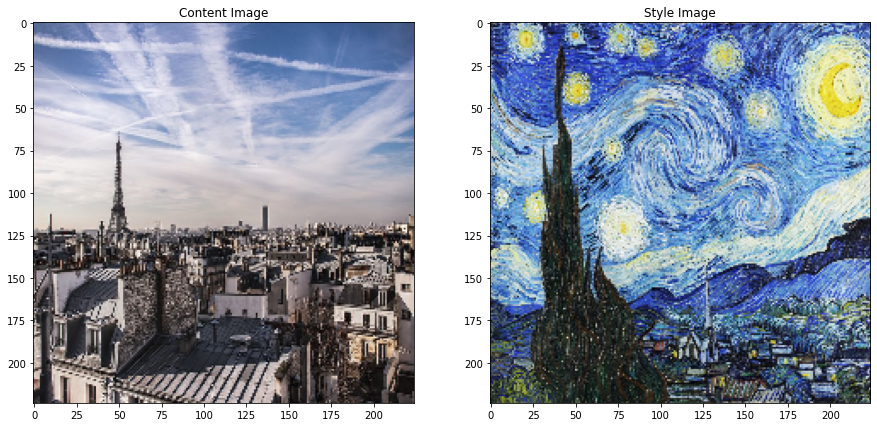

In [ ]:
# Set our image plot parameters and import some modules
import os
import cv2
import time
import functools
import PIL.Image
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display

from PIL import Image
from google.colab.patches import cv2_imshow

mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Load our content and style images with Matplotlib
# content_path = plt.imread('/content/drive/MyDrive/content_5.jpg')
content_path = plt.imread('/content/drive/MyDrive/neural_style_transfer_5_6.jpg')
style_path = plt.imread('/content/drive/MyDrive/neural_style_transfer_5_1.jpg')

# Resize the images size to 224 X 224
content_image = cv2.resize(content_path, (224, 224))
style_image = cv2.resize(style_path, (224, 224))

# Display images pn the screen
ROW, COL = 1, 2
WIDTH, HEIGH = 15, 15
fig, ax = plt.subplots(1, 2, figsize=(WIDTH, HEIGH))
ax[0].set_title("Content Image")
ax[0].imshow(content_image)
ax[1].set_title("Style Image")
ax[1].imshow(style_image)

In [ ]:
# Function that transforms a tensor to image
def tensor_to_image(tensor):

    # To transfrom tensor to image we multiply by 255
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)

    # Convert image to 3 dimension
    if 3 < np.ndim(tensor):
      
        # Not needed the first dimension of image which is the image index 
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    # Return image as PIL format    
    return PIL.Image.fromarray(tensor)

In [ ]:
# Define a function to load an image and limit its maximum dimension to 512 pixels.
def preprocess_img(img):

    max_dim = 256

    img = tf.convert_to_tensor(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

## **2. Implementing our model from scratch**


In [ ]:
# Load VGG19 without the head because we don't look for classification
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# # Print a list of layer names
for layer in vgg.layers:
    print(layer.name)

# We choose a deep layer from the network to extract the fetures
content_layers = ['block5_conv2'] 

# We choose number of intermediate layers from the network to extract the style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',  
                'block4_conv1', 
                'block5_conv1']

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## **3. Build the model**

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):

    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Hold a list of all intermediate layer output
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now we use the function above to get our style extractor and style outputs

In [ ]:
# Preprocess content and style images
style_image = preprocess_img(style_image)
content_image = preprocess_img(content_image)

# Create a model of intermediate layers output to extract style fetures
style_extractor = vgg_layers(style_layers)

# Hold list of fetures style outputs 
style_outputs = style_extractor(style_image*255)

### **Calculate style**

The style of an image described by the means and correlations across the different feature maps. We use this to calculate a **Gram matrix**.

In [ ]:
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result/(num_locations)

## **4. Extract style and content**
Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):

        # Expects float input in [0,1]
        inputs = inputs*255.0
        # This function is meant to adequate image to the format the model requires
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        # Return 6 values and slicing them ( 5 for style layers and 1 for content layers )
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) 
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
# Function return content_dict and style_dict which contain gram metrix 
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00034212758
    max:  38680.836
    mean:  656.7855

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  178464.03
    mean:  21849.95

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  667358.0
    mean:  18467.791

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4261229.0
    mean:  263169.34

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  149821.39
    mean:  2120.8174

Contents:
   block5_conv2
    shape:  (1, 16, 16, 512)
    min:  0.0
    max:  890.44116
    mean:  16.09329


## **5. Running Gradient Descent**

With this style and content extractor, you can now implement the style transfer algorithm!

Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [ ]:
# Set your style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:
opt = tf.optimizers.Adam(learning_rate=0.008, beta_1=0.99, epsilon=1e-1)

# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight=5e-6
content_weight=1e-1

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def style_content_loss(outputs):

    # Variable outputs represent the 'image generated' that returned from extractor
    # Variable outputs returned from function extractor(image=content_image)
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Define style loss fucntion
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    # Normalization the loss function
    style_loss *= style_weight / num_style_layers

    # Define content loss function
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    # Normalization the loss function
    content_loss *= content_weight / num_content_layers

    # Create Style and Content loss
    loss = style_loss + content_loss

    return loss

## **6. Training**

In [ ]:
# Use `tf.GradientTape` to update the image.
@tf.function()
def train_step(image):

    with tf.GradientTape() as tape:

        # Function return content_dict and style_dict which contain gram metrix 
        outputs = extractor(image)
        # Function loss represent Total loss of style and content loss
        loss = style_content_loss(outputs)

    # Calculate the gradient of loss function according to the image
    grad = tape.gradient(loss, image)
    # Update the image with the gradient of loss function 
    opt.apply_gradients([(grad, image)])

    # Normalize the values from 0 to 1
    image.assign(clip_0_1(image))

Now run a few steps to test:

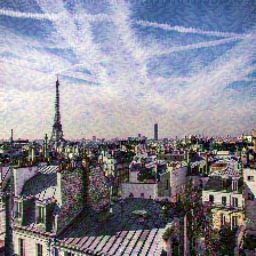

In [ ]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

**It works!**

Since it's working, perform a longer optimization:

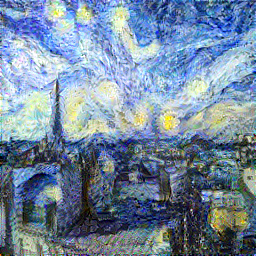

Train step: 2500
Total time: 65.7


In [ ]:
import time
start = time.time()

epochs = 25
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## **7. Save the result**

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **8. Fast Style Transfer using TF-Hub**

Using a simple pretrained model founder on TensorFlow Hub. 

[TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2).

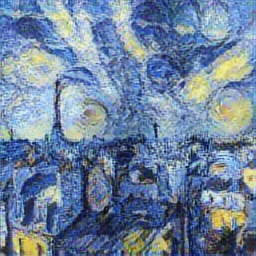

In [ ]:
# Import tensorflow hub which allows us to directly download pretrained models
import tensorflow_hub as hub

# Get our model
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Input our style and content images. The first array's element is the stylized image
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

# Convert the returned tensor to an image
tensor_to_image(stylized_image)